# FIT5120 - Industry Experience  
# Vital Hygiene 
<hr /> 

# Time series Forecasting and Analysis - Campylobacteriosis cases in Victoria
<hr /> 

## Group D32
### - Sarokrishna Ekambarakrishnan (30068029)
### - Pengcheng Ran  (28860578)
### - Sheikh Basil Saeed  (30030978)
### - Yuqian Huang (28934172)

#### Document created by Sarokrishna Ekambarakrishnan (30068029)
<hr /> 

This notebook is used for creating a proper dataset(time-series), splitting into (training and test data), selection and build model by fitting and predicting the number of campylobacteriosis cases in Victoria for the next 5 years.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from matplotlib.pylab import rcParams
#to plot within notebook
import matplotlib.pyplot as plt
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
#import MinMaxScaler and create a new dataframe for LSTM model
from sklearn.preprocessing import StandardScaler
#Augumented dicky fuller test to test stationarity of time series
from statsmodels.tsa.stattools import adfuller
#ARIMA model
from statsmodels.tsa.arima_model import ARIMA
#to check patterns in the data
from statsmodels.tsa.seasonal import seasonal_decompose
#ACF plot and PACF plot to determine the p and q parameter in ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Read the input data file and modifying the data

In [2]:
data = pd.read_excel(r'campylobacter_month.xlsx', sheet_name='Forecast_model_final')


In [3]:
fr = data[data.isnull().any(axis=1)]
fr = fr['Date'].astype(str)
#fr



### convert data column to datetime format

In [4]:
df = data.dropna()
df['Date'] = df['Date'].astype(str)
df.dtypes

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Date      object
Cases    float64
dtype: object

### Initial data 

In [5]:
%matplotlib inline
#setting figure size
rcParams['figure.figsize'] = 20,10
df.head()

,Date,Cases
0,1991-01-01,564.0
1,1991-01-02,614.0
2,1991-01-03,693.0
3,1991-01-04,766.0
4,1991-01-05,732.0


#### No preprocessing is required as only one freature is present inthe dataset

### Converting to datetime datatype and plotting the data

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


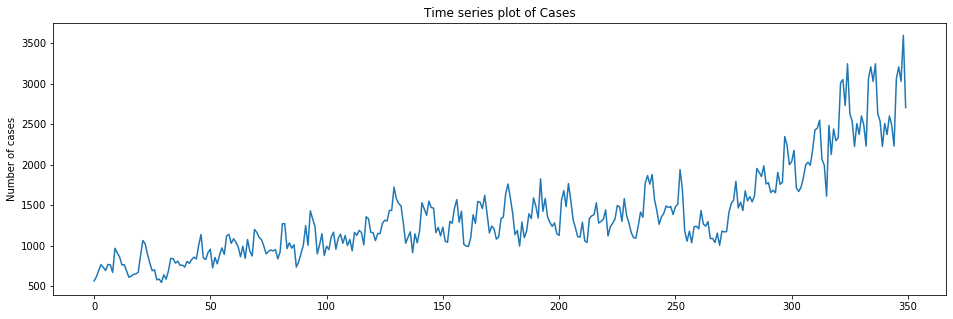

In [6]:
#Conveting data to datetime dtype
df['Date'] = pd.to_datetime(df.Date,format='%Y-%d-%m')

#plot
plt.figure(figsize=(16,5))
plt.plot(df['Cases'], label='Cases')
plt.ylabel('Number of cases')
plt.title('Time series plot of Cases')
plt.show()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


Decomposing time series into its components:


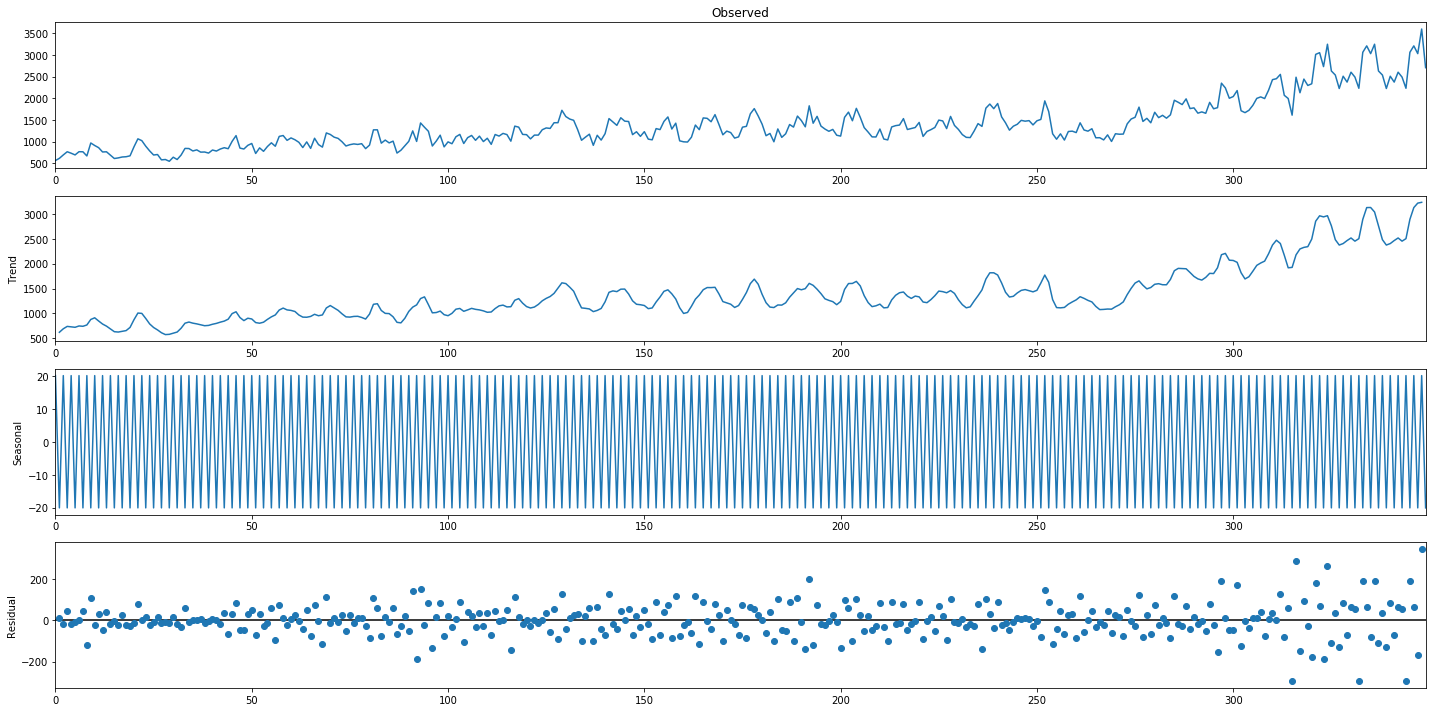

In [7]:
print('Decomposing time series into its components:')

decompose = seasonal_decompose(np.asarray(df['Cases']) , freq = 2)
decompose.plot()
plt.show()

### Augumented Dicky fuller test to test if time series is stationary

In [8]:

result = adfuller(df['Cases'])
print(f'Test statistics : {result[0]}')
print(f'p value : {result[1]}')
if result[1] <= 0.05:
    print('We reject the Null hypothesis. The time series has no unit root and is stationary')
else:
    print('We accept null hypothesis. There is a unit root and time series is not stationary.')

Test statistics : 0.5955577014100886
p value : 0.9875056207991072
We accept null hypothesis. There is a unit root and time series is not stationary.


As we can infer from the plot, the data has trend and seasonality. This is verified using Augumented dicky fuller test. To make data stationary, differencing can be done.

### First order differencing to make series stationary

In [9]:
df_diff = df.copy()

#add previous cases to the next row
df_diff['prev_cases'] = df_diff['Cases'].shift(1)

#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['difference'] = (df_diff['Cases'] - df_diff['prev_cases'])
df_diff.head(10)

,Date,Cases,prev_cases,difference
1,1991-02-01,614.0,564.0,50.0
2,1991-03-01,693.0,614.0,79.0
3,1991-04-01,766.0,693.0,73.0
4,1991-05-01,732.0,766.0,-34.0
5,1991-06-01,693.0,732.0,-39.0
6,1991-07-01,767.0,693.0,74.0
7,1991-08-01,765.0,767.0,-2.0
8,1991-09-01,669.0,765.0,-96.0
9,1991-10-01,968.0,669.0,299.0
10,1991-11-01,910.0,968.0,-58.0


#### Plotting the time series

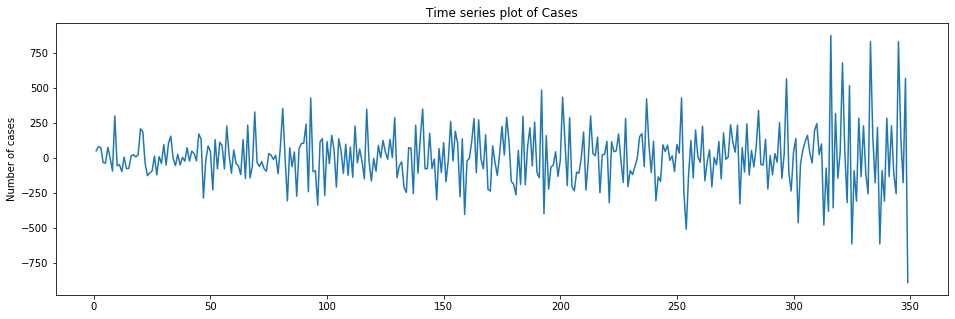

In [10]:
plt.figure(figsize=(16,5))
plt.plot(df_diff['difference'], label='difference')
plt.ylabel('Number of cases')
plt.title('Time series plot of Cases')
plt.show()

#### Augumented dicky fuller test to test stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_diff['difference'])
print(f'Test statistics : {result[0]}')
print(f'p value : {result[1]}')
if result[1] <= 0.05:
    print('We reject the Null hypothesis. The time series has no unit root and is stationary')
else:
    print('We accept null hypothesis. There is a unit root and time series is stationary.')

Test statistics : -4.870819057816322
p value : 3.973429448456066e-05
We reject the Null hypothesis. The time series has no unit root and is stationary


As we can infer from the plot, the mean and variance is not a function of time anymore. So the data is stationary. This is verified using Augumented dicky fuller test.

##### Standard ARIMA Model without seasonality

In [12]:
#model = ARIMA(df['Cases'].astype('float32'), order=(1,1,7))
#results = model.fit()
#results.summary()
#print(np.mean(np.abs(results.resid)))
#plot_acf(results.resid, lags = 100)
#plot_pacf(results.resid, lags = 50)
#plt.show()
df[-10:]

,Date,Cases
340,2019-05-01,2508.0
341,2019-06-01,2373.0
342,2019-07-01,2601.0
343,2019-08-01,2488.0
344,2019-09-01,2230.0
345,2019-10-01,3060.0
346,2019-11-01,3208.0
347,2019-12-01,3029.0
348,2020-01-01,3597.0
349,2020-02-01,2705.0


### SARIMAX - Seasonal Arima model

In [13]:
df.set_index('Date', inplace = True)
df_train = df[:'2019-01-01']
df_test = df['2019-01-01':]
from statsmodels.tsa.statespace.sarimax import SARIMAX

model1 = SARIMAX(df.astype('float32'), order=(0,1,7), seasonal_order = (1,1,1,12))
result1 = model1.fit()
result1.summary()


/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Cases   No. Observations:                  350
Model:             SARIMAX(0, 1, 7)x(1, 1, [1], 12)   Log Likelihood               -2135.917
Date:                              Tue, 02 Jun 2020   AIC                           4291.833
Time:                                      11:23:55   BIC                           4330.034
Sample:                                           0   HQIC                          4307.059
                                              - 350                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4248      0.056     -7.566      0.000      -0.535      -0.315
ma.L2         -0.0477      0.060     -0.791      0.429      -0.166       0.070
ma.L3         -0.1257      0.055     -2.300      0.021      -0.233      -0.019
ma.L4         -0.0667      0.059     -1.128      0.259      -0.183       0.049
ma.L5          0.0689      0.053      1.290      0.197      -0.036       0.174
ma.L6         -0.0306      0.062     -0.492      0.623      -0.153       0.091
ma.L7         -0.1013      0.061     -1.668      0.095      -0.220       0.018
ar.S.L12       0.0025      0.072      0.035      0.972      -0.138       0.143
ma.S.L12      -0.7385      0.060    -12.309      0.000      -0.856      -0.621
sigma2      1.819e+04   1212.958     14.997      0.000    1.58e+04    2.06e+04
===================================================================================
Ljung-Box (Q):                       34.85   Jarque-Bera (JB):                41.56
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               3.34   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ACF and PACF plot to determine the parameters of ARIMA

Mean Absolute Error : 101.58795564987987


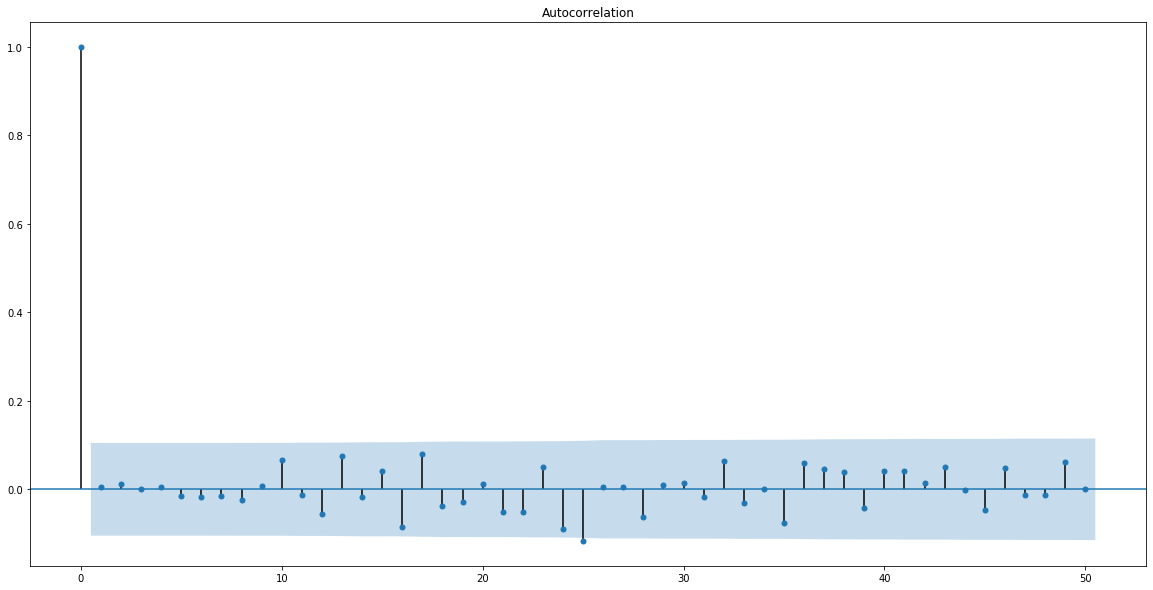

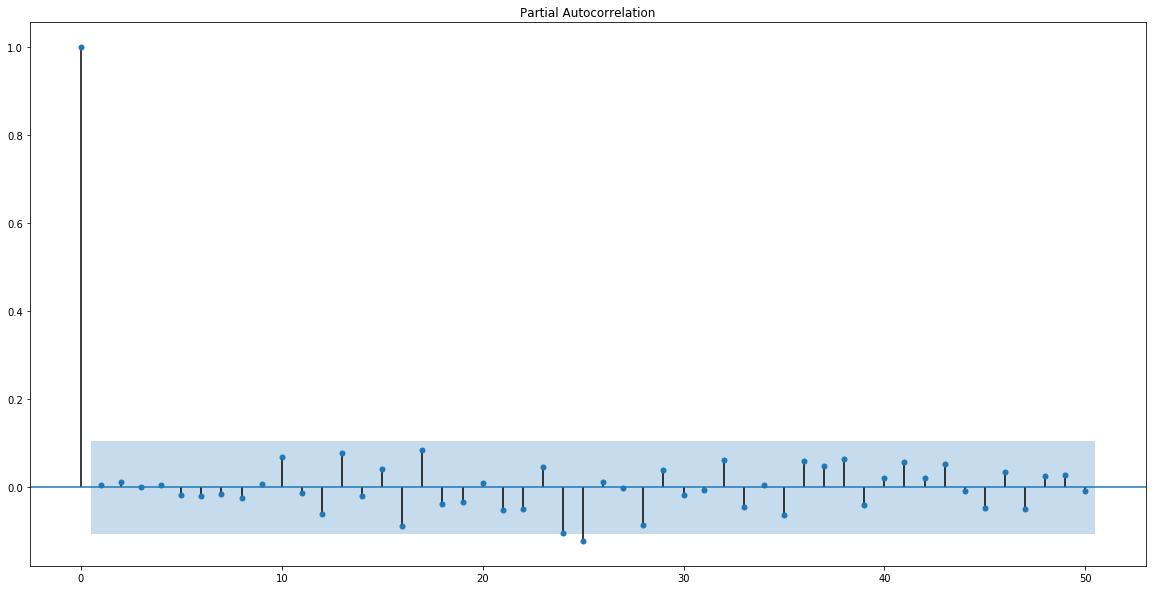

In [14]:
print(f'Mean Absolute Error : {np.mean(np.abs(result1.resid))}')
plot_acf(result1.resid, lags = 50)
plot_pacf(result1.resid, lags = 50)
plt.show()


##### Plot Diagnostics

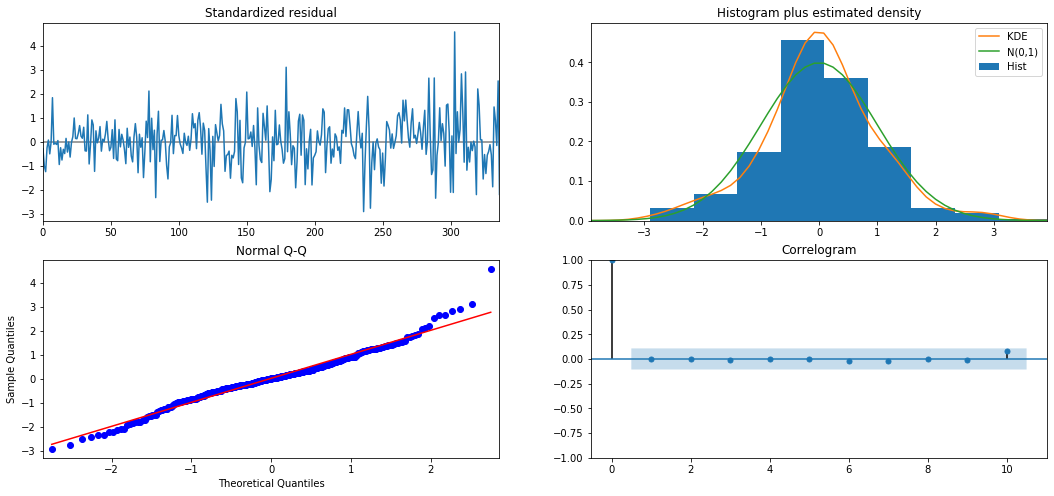

In [15]:
result1.plot_diagnostics(figsize=(18, 8))
plt.show()

#### Forecasting the future

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


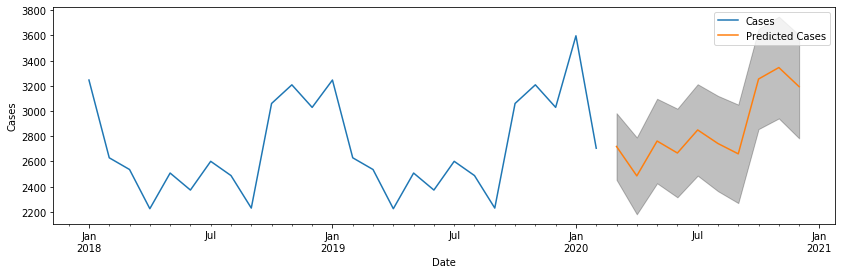

In [16]:
pred_uc = result1.get_forecast(steps=10)
pred_ci = pred_uc.conf_int()
ax = df['2018-01-01':].plot(label='observed', figsize=(14, 4))
temp = pd.DataFrame(pred_uc.predicted_mean)
temp['Date'] = fr
temp = temp.rename(columns = {0 : 'Predicted Cases'})
temp['Date'] = pd.to_datetime(temp.Date,format='%Y-%d-%m')
temp = temp.set_index('Date')
temp.plot(ax=ax, label='Forecast')
pred_ci['Date'] = temp.index
pred_ci.set_index('Date', inplace = True)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
plt.legend()
plt.show()

In [17]:
df1 = df.copy()


df1 = df1.drop(df1.index[:200])
df1

,Cases
Date,
2007-09-01,1127.0
2007-10-01,1560.0
2007-11-01,1680.0
2007-12-01,1481.0
2008-01-01,1767.0
2008-02-01,1560.0
2008-03-01,1323.0
2008-04-01,1220.0
2008-05-01,1109.0


## Forecast of the number of campylobacteriosis cases in Australia for next 5 years (2009-2025)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


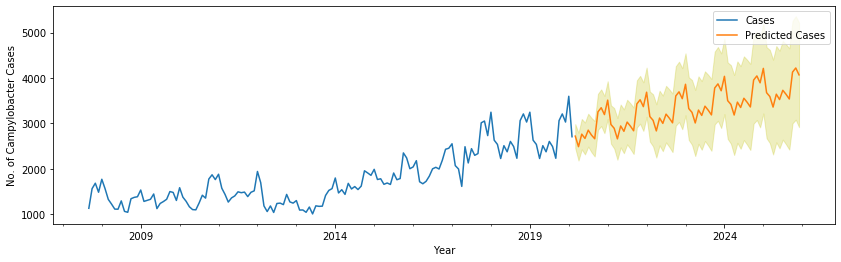

In [18]:

pred_uc = result1.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()

ax = df1.plot(label='observed', figsize=(14, 4))
temp = pd.DataFrame(pred_uc.predicted_mean)
temp['Date'] = fr
temp = temp.rename(columns = {0 : 'Predicted Cases'})
temp['Date'] = pd.to_datetime(temp.Date,format='%Y-%d-%m')
temp = temp.set_index('Date')
temp.plot(ax=ax, label='Forecast')
pred_ci['Date'] = temp.index
pred_ci.set_index('Date', inplace = True)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('No. of Campylobacter Cases')
#plt.ion()
plt.legend()
plt.show()


## Forecast of the number of campylobacteriosis cases in Australia for next 5 years (1992-2025)

/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


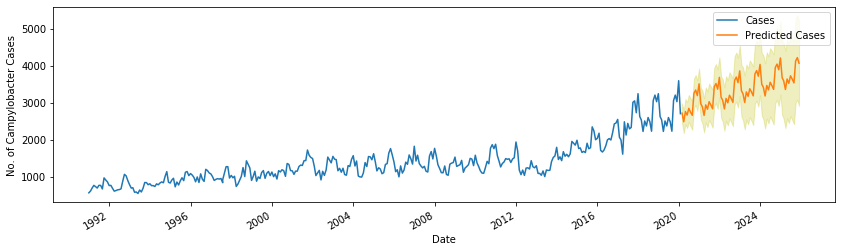

In [19]:
#plt.ion()
pred_uc = result1.get_forecast(steps=70)
pred_ci = pred_uc.conf_int()

ax = df.plot(label='observed', figsize=(14, 4))
temp = pd.DataFrame(pred_uc.predicted_mean)
temp['Date'] = fr
temp = temp.rename(columns = {0 : 'Predicted Cases'})
temp['Date'] = pd.to_datetime(temp.Date,format='%Y-%d-%m')
temp = temp.set_index('Date')
temp.plot(ax=ax, label='Forecast')
pred_ci['Date'] = temp.index
pred_ci.set_index('Date', inplace = True)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='y', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('No. of Campylobacter Cases')
#plt.ion()
plt.legend()
plt.show()

In [23]:
pred_ci.tail(12)

,lower Cases,upper Cases
Date,,
2025-01-01,3218.394951,5206.206985
2025-02-01,2671.196883,4680.779610
2025-03-01,2564.312857,4620.147176
2025-04-01,2314.146425,4403.855243
2025-05-01,2582.482666,4704.369579
2025-06-01,2449.846803,4600.521006
2025-07-01,2640.479282,4818.090779
2025-08-01,2537.734913,4743.453372
2025-09-01,2420.559156,4653.368213


### The accuracy can be measures through RMSE and MAE

In [20]:
pred_val = list(pred_uc.predicted_mean)
resid = [a - b for a, b in zip( pred_val, list(df['2019-01-01':]['Cases']))]
print(f'MAE : {np.sum(np.abs(resid[:]))/(len(pred_val))}')
print(f'RMSE : {np.sqrt(np.sum(np.square(resid[:]))/(len(pred_val)))}')

MAE : 74.77281856279453
RMSE : 215.31533601648903


As RMSE is smaller, the above model can be taken into account for the foreacast model